# Quantum Circuit to find XMAS

This quantum circuit will find the binary encoding of XMAS in a superposition of different sublists of a longer list. The longer list is test_string = 'MMMSXXMASM', where this is broken down into the sublists sub_strings = ['MMMS', 'MMSX', ...].



In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

Here we setup the binary representation of the sub-strings and the target strings

In [2]:
# Get binary representation of a number (since n<=4 we only need two digits)
binary = lambda n: format(n, '02b')

# Target string - string we are looking for

target_string = 'XMAS'

dict = {'X': 0, 'M': 1, 'A': 2, 'S': 3}

# Convert into binary with mappings X->0, M->1, A->2, S->3
target_nums = [dict[i] for i in target_string]

target = ''.join([binary(i) for i in target_nums])

# Test string to search
test_string = 'MMMSXXMASM'

N = len(test_string)

test_nums = [dict[i] for i in test_string]
test = ''.join([binary(i) for i in test_nums])

# Split into sub-lists of length 8
sub_test = [test[2*i:2*i + 8] for i in range(N-3)]

print(f'Sub-lists: {sub_test}')
print(f'Targer binary encoding: {target}')

Sub-lists: ['01010111', '01011100', '01110000', '11000001', '00000110', '00011011', '01101101']
Targer binary encoding: 00011011


Now we need to embed these sub-lists into a superposition of quantum states. I would design the circuit myself, but state preparation is a very active field of research, and I am lazy, so I will just use a qiskit subroutine to build the initialisation circuit.

In [3]:
circ = QuantumCircuit(9)

# Function to undo the binary encodings
undo_binary = lambda n: int(n, 2)

# Get locations of 1's to implement into computational basis
initial_states = [undo_binary(i) for i in sub_test]

N_states = len(initial_states)

# Implement the 1's in the correct location for the computational basis
state_vector = np.zeros(2**8)
for state in initial_states:
    state_vector[state] = 1/np.sqrt(N_states)

# Get state preparation circuit
state_prep = StatePreparation(state_vector)

Now we will perform a Grover's search for the target state

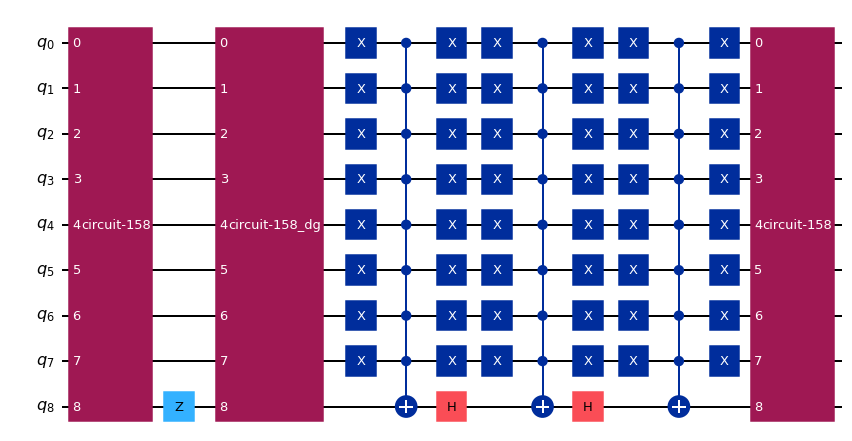

In [4]:
oracle = QuantumCircuit(9)

# Add gates at the appropriate positions - in this case we are looking for the state 00011011

oracle.append(state_prep, [0,1,2,3,4,5,6,7])

oracle.mcx([0,1,3,4], 8)

oracle_inv = oracle.inverse()

circ.append(oracle, [0,1,2,3,4,5,6,7,8])
circ.z(8)

circ.append(oracle_inv, [0,1,2,3,4,5,6,7,8])

# Start of diffuser
for i in range(8):
    circ.x(i)
circ.mcx([0,1,2,3,4,5,6,7], 8)
for i in range(8):
    circ.x(i)

# Middle of diffuser
circ.h(8)
for i in range(8):
    circ.x(i)
circ.mcx([0,1,2,3,4,5,6,7], 8)
for i in range(8):
    circ.x(i)
circ.h(8)

# End of diffuser
for i in range(8):
    circ.x(i)
circ.mcx([0,1,2,3,4,5,6,7], 8)
for i in range(8):
    circ.x(i)


circ.append(oracle, [0,1,2,3,4,5,6,7,8])

circ.draw('mpl')

Now we will use statevector simulation to simulate the quantum circuit

{'000000110': (-0.16198477414679527-2.3991029868411782e-15j), '001010111': (-0.16198477414679122-1.2292922990969525e-15j), '001011100': (-0.1619847741467944-3.881389182984057e-15j), '001101101': (-0.16198477414679074-1.5797999076588484e-15j), '001110000': (-0.16198477414679469-4.187382521969527e-15j), '011000001': (-0.16198477414679216-2.041519656847058e-15j), '100011011': (-0.9179137201651657-5.467848396278896e-15j)}
['XXMA', 'MMMS', 'MMSX', 'MASM', 'MSXX', 'SXXM', 'XMAS']


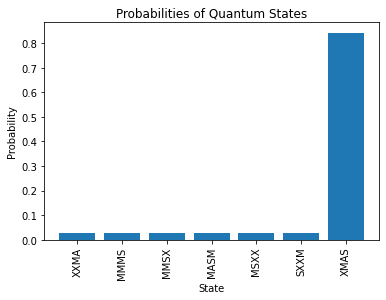

In [5]:

state = Statevector.from_int(0, 2**9)

state = state.evolve(circ)

threshold = 0.1
filtered_amplitudes = {k: v for k, v in state.to_dict().items() if abs(v) > threshold}
print(filtered_amplitudes)

# Plot the probabilities of the state
probabilities = {k: abs(v)**2 for k, v in filtered_amplitudes.items()}

keys = list(probabilities.keys())
nums = [[undo_binary(i[2*j+1:2*j+3]) for j in range(4)] for i in keys]

letters = [''.join([list(dict.keys())[list(dict.values()).index(num)] for num in sublist]) for sublist in nums]
print(letters)

plt.bar(letters, probabilities.values())
plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Probabilities of Quantum States')
plt.xticks(rotation=90)
plt.show()

We have found XMAS (merry christmas!). Be warned, the code is incredibly unstable so if you try to change anything be prepared for a lot of warnings